# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from inf5860.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The code uses a traning set, validation set, test set. The small development set is not not necessarily used)

In [129]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'inf5860/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data to use the split the training data into a training and a validation subset
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

[ 130.64189796  135.98173469  132.47391837 ...,  126.64218367  125.86195918
  114.39957143]
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **inf5860/classifiers/softmax.py**. 
The loss for one sample is 
$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in}$

You should sum over all samples

In [32]:
# First implement the naive softmax loss function with nested loops.
# Open the file inf5860/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from inf5860.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.348643
sanity check: 2.302585


## Inline Question 1:

To answer inline questions: double click on this cell and you will be able to edit it. Fill in your text answer below.

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Based on the core of the loss function L_i, we normalise over all matrixmultiplied classes with pixels of image i. This in some way is basing a standard value of (1 class)/( all classes) = 1/10. E.g if we were to guess a class randomly, we can see this as a probability of (1 class)/(all classes), this also bases on that we have equal amount of occurences of classes in the training set.*


# Implement the cross entropy loss (softmax loss) 

Include regularization in softmax_loss_naive and compute also the gradient of the loss function. 

In [68]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool. We talk about gradient checking on the lecture 7.2. It is pre-implemented. 
# The numeric gradient should be close to the analytic gradient.
from inf5860.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print('----------------------------------------------------------------------')
# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 4.248919 analytic: 4.248919, relative error: 1.499435e-08
numerical: 0.154861 analytic: 0.154861, relative error: 2.179182e-08
numerical: 0.197981 analytic: 0.197981, relative error: 3.154517e-08
numerical: 2.571677 analytic: 2.571677, relative error: 1.122780e-08
numerical: -2.796834 analytic: -2.796834, relative error: 6.623738e-09
numerical: -0.566565 analytic: -0.566565, relative error: 2.952531e-09
numerical: 1.656351 analytic: 1.656351, relative error: 8.589072e-10
numerical: 0.062166 analytic: 0.062166, relative error: 3.564327e-07
numerical: 1.066349 analytic: 1.066349, relative error: 2.790367e-08
numerical: 0.180032 analytic: 0.180032, relative error: 2.246045e-07
----------------------------------------------------------------------
numerical: 2.716589 analytic: 2.716589, relative error: 5.217723e-10
numerical: 0.547265 analytic: 0.547265, relative error: 2.133047e-08
numerical: 0.829565 analytic: 0.829565, relative error: 1.657202e-08
numerical: 0.209424 analytic

Since the numbers are small, the gradient are also small, and your difference should also be very small, arbound e-07 or smaller

In [175]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from inf5860.classifiers.softmax import softmax_loss_vectorized

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.343147e+00 computed in 0.141549s
vectorized loss: 2.343147e+00 computed in 0.003759s
Loss difference: 0.000000
Gradient difference: 0.000000


The difference in loss should be smaller than 0.1, and the gradient difference close to 0. 


In [176]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.33 on the validation set.
from inf5860.classifiers.linear_classifier import Softmax

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# save the best trained softmax classifer in best_softmax.                     #
################################################################################
for lr in np.linspace(learning_rates[0], learning_rates[1], 5):
    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], 5):
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=True)        
        y_train_acc = (softmax.predict(X_train) == y_train).mean()
        y_val_acc = (softmax.predict(X_val) == y_val).mean()
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 385.609642
iteration 100 / 1000: loss 232.689478
iteration 200 / 1000: loss 141.599987
iteration 300 / 1000: loss 86.475931
iteration 400 / 1000: loss 52.990445
iteration 500 / 1000: loss 32.917083
iteration 600 / 1000: loss 20.706996
iteration 700 / 1000: loss 13.312630
iteration 800 / 1000: loss 8.841685
iteration 900 / 1000: loss 6.146686
iteration 0 / 1000: loss 482.354397
iteration 100 / 1000: loss 257.484533
iteration 200 / 1000: loss 138.143301
iteration 300 / 1000: loss 74.604595
iteration 400 / 1000: loss 40.766977
iteration 500 / 1000: loss 22.634523
iteration 600 / 1000: loss 13.137565
iteration 700 / 1000: loss 7.869906
iteration 800 / 1000: loss 5.232166
iteration 900 / 1000: loss 3.754658
iteration 0 / 1000: loss 575.247701
iteration 100 / 1000: loss 271.098485
iteration 200 / 1000: loss 128.629381
iteration 300 / 1000: loss 61.433770
iteration 400 / 1000: loss 30.086015
iteration 500 / 1000: loss 15.215687
iteration 600 / 1000: loss 8.303503
iter

In [177]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


Check your accuracy, you should get at least 0.33. More than 0.35 is also possible. 

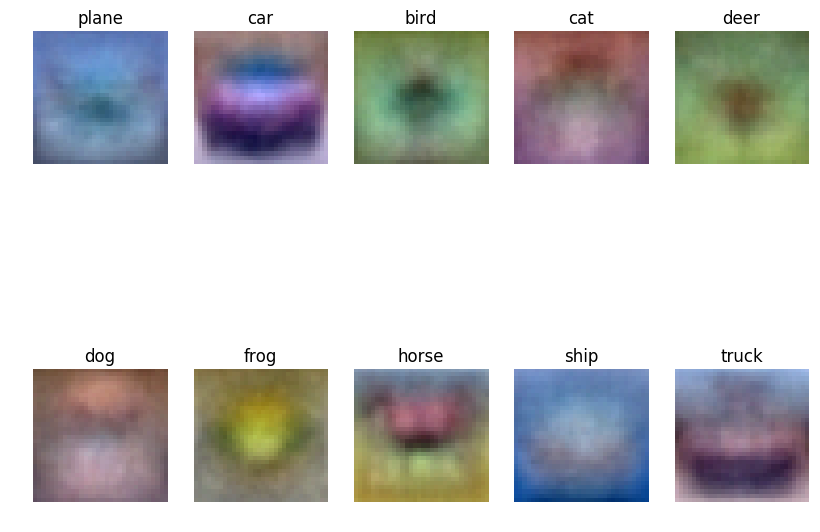

In [178]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])